In [1]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import pickle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Functions

In [2]:
def round_up_to_nearest_five_minutes(ts):
    # Parse the timestamp
    dt = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
    
    # Calculate minutes to add to round up to the nearest 5 minutes
    minutes_to_add = (5 - dt.minute % 5) % 5
    if minutes_to_add == 0 and dt.second == 0:
        # If exactly on a 5 minute mark and second is 0, no need to add time
        minutes_to_add = 0
    
    # Add the necessary minutes
    new_dt = dt + timedelta(minutes=minutes_to_add)
    
    # Return the new timestamp in the same format
    return new_dt.strftime( "%d-%m-%Y %H:%M:%S")

In [3]:
# Need to set the 
def read_ohio(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts'])
            entry0['ts'] = adjusted_ts
        ts = entry0['ts']
        entry0['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            # t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            # t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            # delt = t1 - t0
            # if category == "glucose_level":
            #     if delt <= interval_timedelta:
            #         res[-1].append([entry])
            #     else:
            #         res.append([entry])
            # else:
            ts = entry['ts']
            if round == True:
                adjusted_ts = round_up_to_nearest_five_minutes(ts)
                entry['ts'] = adjusted_ts
            ts = entry['ts']
            entry['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
            res.append([entry])
    return res


In [4]:
def transfer_into_table(glucose):
    glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

    # Create the multi-channel database
    g_data = []
    for timestamp in glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': glucose_dict[timestamp],
            # 'meal_type': None,
            # 'meal_carbs': 0
        }
        
        g_data.append(record)

    # Create DataFrame
    glucose_df = pd.DataFrame(g_data)

    # Convert glucose values to numeric type for analysis
    glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])
    glucose_df['glucose_value'] = glucose_df['glucose_value'] # Shrink to its 1/100 for scaling

    return glucose_df

In [5]:
def segement_data_as_15min(data):
    df = pd.DataFrame(data)

    # Calculate time differences
    df['time_diff'] = df['timestamp'].diff()

    # Identify large gaps
    df['new_segment'] = df['time_diff'] > pd.Timedelta(minutes=15)

    # Find indices where new segments start
    segment_starts = df[df['new_segment']].index

    # Initialize an empty dictionary to store segments
    segments = {}
    prev_index = 0

    # Loop through each segment start and slice the DataFrame accordingly
    for i, start in enumerate(segment_starts, 1):
        segments[f'segment_{i}'] = df.iloc[prev_index:start].reset_index(drop=True)
        prev_index = start

    # Add the last segment from the last gap to the end of the DataFrame
    segments[f'segment_{len(segment_starts) + 1}'] = df.iloc[prev_index:].reset_index(drop=True)

    # Optionally remove helper columns from each segment
    for segment in segments.values():
        segment.drop(columns=['time_diff', 'new_segment'], inplace=True)
    
    return segments

In [6]:
def find_closest_glucose_index(glucose_df, meal_time, threshold_seconds=300):
    time_diffs = (glucose_df['timestamp'] - meal_time).abs()
    within_threshold = time_diffs < pd.Timedelta(seconds=threshold_seconds)
    if within_threshold.any():
        closest_index = time_diffs[within_threshold].idxmin()
        return closest_index
    return None

def update_segments_with_meals(segments, meal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['carb_effect'] = 0

        for index, meal_row in meal_df.iterrows():
            meal_time = meal_row['ts']
            closest_glucose_idx = find_closest_glucose_index(segment_df, meal_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'carb_effect'] = int(meal_row['carb_effect'])
                meal_df.loc[index, 'assigned'] = True


    return segments

In [7]:
def expand_meal_entry(meal_row):
    meal_time = meal_row['ts']
    end_effect_time = meal_time + timedelta(hours=3)
    carb = float(meal_row['carbs'])

    c_eff_list = [0, 0, 0, ]

    for i in range(1, 10):
        c_eff = (i * 0.111) * carb
        if c_eff > carb:
            print("C_eff > carb")
            c_eff = carb
        c_eff_list.append(c_eff)

    for j in range(1, 25):
        c_eff = (1 - (j * 0.028)) * carb
        if c_eff < 0:
            print("C_eff < 0")
            c_eff = 0
        c_eff_list.append(c_eff)

    timestamp_list = pd.date_range(start=meal_time, end=end_effect_time, freq='5min')
    d = {"ts": timestamp_list[:-1], "carb_effect": c_eff_list}
    meal_effect_df = pd.DataFrame(data = d)

    return meal_effect_df

    

In [8]:
def read_ohio_bolus_tempbasal(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        if len(item) == 0:
            continue  # Skip if the item has no children
            
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_begin'])
            entry0['ts_begin'] = adjusted_ts
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_end'])
            entry0['ts_end'] = adjusted_ts
        
        entry0['ts_begin'] = datetime.strptime(entry0['ts_begin'], "%d-%m-%Y %H:%M:%S")
        entry0['ts_end'] = datetime.strptime(entry0['ts_end'], "%d-%m-%Y %H:%M:%S")

        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            ts_begin = entry['ts_begin']
            ts_end = entry['ts_end']
            if round == True:
                adjusted_ts_begin = round_up_to_nearest_five_minutes(ts_begin)
                entry['ts_end'] = adjusted_ts_begin
                adjusted_ts_end = round_up_to_nearest_five_minutes(ts_end)
                entry['ts_end'] = adjusted_ts_end
            entry['ts_begin'] = datetime.strptime(entry['ts_begin'], "%d-%m-%Y %H:%M:%S")
            entry['ts_end'] = datetime.strptime(entry['ts_end'], "%d-%m-%Y %H:%M:%S")
            if category == "bolus":
                if entry['ts_begin'] != entry['ts_end']:
                    print("Unequal: begin: " + str(entry['ts_begin']) + "end: " + str(entry['ts_end']))
            res.append([entry])
    return res

In [9]:
def expand_bolus_entry(bolus_row):
    bolus_time = bolus_row['ts_begin']
    timestamp_list = [bolus_time, ]
    # end_effect_time = bolus_time + timedelta(hours=3)
    dose = float(bolus_row['dose'])

    b_eff_list = [dose, ]
    b_eff = dose

    i = 1
    while b_eff > 0:
        b_eff = dose - (i * 0.07)
        b_eff_list.append(b_eff)
        timestamp_list.append(bolus_time + timedelta(minutes=5 * i))
        i += 1
    # print(len(timestamp_list[:-1]))
    # print(len(b_eff_list[:-1]))


    d = {"ts": timestamp_list[:-1], "bolus_effect": b_eff_list[:-1]}
    bolus_effect_df = pd.DataFrame(data = d)

    return bolus_effect_df

In [10]:
def update_segments_with_bolus(segments, bolus_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['bolus_effect'] = 0

        for index, bolus_row in bolus_df.iterrows():
            bolus_time = bolus_row['ts']
            closest_glucose_idx = find_closest_glucose_index(segment_df, bolus_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'bolus_effect'] = float(bolus_row['bolus_effect'])
                bolus_df.loc[index, 'assigned'] = True


    return segments

In [11]:
def compute_accumulated_step(window_list, step_df):
    start_time = window_list[0]
    end_time = window_list[-1]

    step_list = []
    counter = 1
    for idx, step_row in step_df.iterrows():
        
        if step_row['ts'] >= start_time and step_row['ts'] < end_time:
            step_list.append(counter * float(step_row['value']))
            counter += 1

        if step_row['ts'] >= end_time:
            break
    # print("length of step_list ", len(step_list))
    if len(step_list) == 0:
        return None
    accumulate_step = sum(step_list)/len(step_list)
    return accumulate_step
    

In [12]:
def prepare_dataset(segments, ph, history):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carb_effect'] = pd.to_numeric(segment_df['carb_effect'], errors='coerce')
        segment_df['steps'] = pd.to_numeric(segment_df['steps'], errors='coerce')
        segment_df['steps'] = segment_df['steps'] 
        segment_df['bolus_effect'] = pd.to_numeric(segment_df['bolus_effect'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - (history-1+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + history-1 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+history-1
            features = segment_df.loc[i:i+history-1, ['glucose_value', 'carb_effect', 'bolus_effect', 'steps']] # .values.flatten() # 'carb_effect', 'bolus_effect', 'steps'
            # Extracting label for index i+21
            # Do the label transform
            label = segment_df.loc[i+history-1+ph, 'glucose_value'] - segment_df.loc[i+history-1, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history-1+ph, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, raw_glu_list

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim


class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(StackedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob).to(device)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True).to(device)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 512).to(device)
        self.fc2 = nn.Linear(512, 128).to(device)
        self.fc3 = nn.Linear(128, output_size).to(device)
        
        # Activation functions
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size from the input tensor

        # Initialize hidden and cell state for the first LSTM layer
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # First LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        # Dropout layer
        out = self.dropout(out)
        
        # Initialize hidden and cell state for the second LSTM layer
        h1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c1 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Second LSTM layer
        out, (hn, cn) = self.lstm2(out, (h1, c1))
        
        # Fully connected layers
        out = out[:, -1, :]  # Get the last time step output
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out



# Implementation

In [15]:
filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/591-ws-training.xml"
glucose = read_ohio(filepath, "glucose_level", True)
glucose_df = transfer_into_table(glucose)
segments = segement_data_as_15min(glucose_df)

#Include meal:
meal = read_ohio(filepath, "meal", True)
flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist
# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)
meal_df['assigned'] = False
empty_d = {"ts": [], "carb_effect": []}
whole_meal_effect_df = pd.DataFrame(data = empty_d)
for index, meal_row in meal_df.iterrows():
    meal_effect_df = expand_meal_entry(meal_row)

    # Merge the DataFrames on the 'ts' column with an outer join
    merged_df = pd.merge(whole_meal_effect_df, meal_effect_df, on='ts', how='outer', suffixes=('_df1', '_df2'))

    # Fill NaN values with 0 for the carb_effect columns
    merged_df['carb_effect_df1'] = merged_df['carb_effect_df1'].fillna(0)
    merged_df['carb_effect_df2'] = merged_df['carb_effect_df2'].fillna(0)

    # Sum the carb_effect values
    merged_df['carb_effect'] = merged_df['carb_effect_df1'] + merged_df['carb_effect_df2']

    # Keep only the required columns
    whole_meal_effect_df = merged_df[['ts', 'carb_effect']]

whole_meal_effect_df['assigned'] = False
meal_updated_segments = update_segments_with_meals(segments, whole_meal_effect_df)

C:\Users\username\AppData\Local\Temp\ipykernel_40720\3839196072.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_meal_effect_df['assigned'] = False


In [ ]:
# Include bolus:
bolus = read_ohio_bolus_tempbasal(filepath, "bolus", True)
flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist
# Convert to DataFrame
bolus_df = pd.DataFrame(flattened_bolus_data)

empty_b = {"ts": [], "bolus_effect": []}
whole_bolus_effect_df = pd.DataFrame(data = empty_b)

for index, bolus_row in bolus_df.iterrows():
    bolus_effect_df = expand_bolus_entry(bolus_row)

    # Merge the DataFrames on the 'ts' column with an outer join
    merged_df = pd.merge(whole_bolus_effect_df, bolus_effect_df, on='ts', how='outer', suffixes=('_df1', '_df2'))

    # Fill NaN values with 0 for the carb_effect columns
    merged_df['bolus_effect_df1'] = merged_df['bolus_effect_df1'].fillna(0)
    merged_df['bolus_effect_df2'] = merged_df['bolus_effect_df2'].fillna(0)
    

    # Sum the carb_effect values
    merged_df['bolus_effect'] = merged_df['bolus_effect_df1'] + merged_df['bolus_effect_df2']

    # Keep only the required columns
    whole_bolus_effect_df = merged_df[['ts', 'bolus_effect']]

whole_bolus_effect_df["assigned"] = False
bolus_updated_segments = update_segments_with_bolus(meal_updated_segments, whole_bolus_effect_df)

In [17]:
# Process step information
steps = read_ohio(filepath, "basis_steps", True)
flattened_steps_data = [item[0] for item in steps]  # Take the first (and only) item from each sublist
# Convert to DataFrame
step_df = pd.DataFrame(flattened_steps_data)

accumulate_step_list = []
# test_segment = segments["segment_1"]
for segment_name, segment_df in bolus_updated_segments.items():
    accumulate_step_list = []
    for index, cgm_row in segment_df.iterrows():
        current = cgm_row['timestamp']
        first_timestamp = current - timedelta(minutes=50)
        window_list = pd.date_range(start=first_timestamp, end=current, freq='5min')

        accumulated_step = compute_accumulated_step(window_list, step_df)
        accumulate_step_list.append(accumulated_step)
    segment_df['steps'] = accumulate_step_list

In [18]:
# Save the processed data CAREFULL!!!
# Specify the file name
filename = '591_combined_segments_noshrink.pkl'

# Save the dictionary to a file
with open(filename, 'wb') as f:
    pickle.dump(bolus_updated_segments, f)


## Load processed data

In [105]:
# Load processed data
filename = '591_combined_segments.pkl'
# Load the dictionary from the file
with open(filename, 'rb') as f:
    loaded_df_dict = pickle.load(f)

# Verify the content

print(loaded_df_dict['segment_1'])
print(loaded_df_dict['segment_2'])
bolus_updated_segments = loaded_df_dict

              timestamp  glucose_value  carb_effect  bolus_effect  steps
0   2021-11-30 17:10:00           1.60         0.45         1.975   15.6
1   2021-11-30 17:15:00           1.58         0.65         1.940   12.5
2   2021-11-30 17:20:00           1.60         0.80         1.905    9.4
3   2021-11-30 17:25:00           1.66         0.95         1.870    6.3
4   2021-11-30 17:30:00           1.75         1.15         1.835    3.2
..                  ...            ...          ...           ...    ...
404 2021-12-02 02:50:00           1.71         0.00         0.555    0.0
405 2021-12-02 02:55:00           1.69         0.00         0.520    0.0
406 2021-12-02 03:00:00           1.67         0.00         0.485    0.0
407 2021-12-02 03:05:00           1.64         0.00         0.450    0.0
408 2021-12-02 03:10:00           1.62         0.00         0.415    0.0

[409 rows x 5 columns]
              timestamp  glucose_value  carb_effect  bolus_effect  steps
0   2021-12-02 03:40:00    

In [106]:
# Prepare for training
features_list, labels_list, raw_glu_list = prepare_dataset(bolus_updated_segments, 6, 6)

# Build training and validation loader
features_array = np.array(features_list)
labels_array = np.array(raw_glu_list) # Maybe need to replace this

# For one channel
# data_sequences = np.reshape(features_array, (features_array.shape[0], features_array.shape[1], 1))
X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, shuffle= False)

len of features_list 10561
len of labels_list 10561


In [107]:
X_train.shape

(8448, 6, 4)

In [108]:
# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # The original batch size = 128, however, training on 128 cannot get the model fully trained, so change to 32.
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [109]:
input_size = 4 # Number of input features
hidden_size = 128  # Hidden vector size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Single output
dropout_prob = 0.2  # Dropout probability



model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob) # input_size, hidden_size, num_layers, output_size, dropout_prob
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [110]:
num_epochs =100
for epoch in range(num_epochs):
    model.train()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')


    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            total_loss += loss.item()
        
        avg_loss = total_loss / len(val_loader)
        print(f'Test Loss: {avg_loss:.4f}')

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {rmse}')

c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Training Loss: 2.1825
Test Loss: 1.5359


c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([65])) that is different to the input size (torch.Size([65, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/100], Training Loss: 0.6716
Test Loss: 0.4872
Epoch [3/100], Training Loss: 0.3138
Test Loss: 0.2970
Epoch [4/100], Training Loss: 0.1527
Test Loss: 0.2379
Epoch [5/100], Training Loss: 0.0995
Test Loss: 0.2240
Epoch [6/100], Training Loss: 0.0839
Test Loss: 0.2207
Epoch [7/100], Training Loss: 0.0801
Test Loss: 0.2191
Epoch [8/100], Training Loss: 0.0763
Test Loss: 0.2182
Epoch [9/100], Training Loss: 0.0763
Test Loss: 0.2175
Epoch [10/100], Training Loss: 0.0752
Test Loss: 0.2172
Epoch [11/100], Training Loss: 0.0760
Test Loss: 0.2168
Epoch [12/100], Training Loss: 0.0754
Test Loss: 0.2163
Epoch [13/100], Training Loss: 0.0729
Test Loss: 0.2157
Epoch [14/100], Training Loss: 0.0741
Test Loss: 0.2154
Epoch [15/100], Training Loss: 0.0733
Test Loss: 0.2153
Epoch [16/100], Training Loss: 0.0730
Test Loss: 0.2154
Epoch [17/100], Training Loss: 0.0742
Test Loss: 0.2149
Epoch [18/100], Training Loss: 0.0736
Test Loss: 0.2148
Epoch [19/100], Training Loss: 0.0730
Test Loss: 0.2148


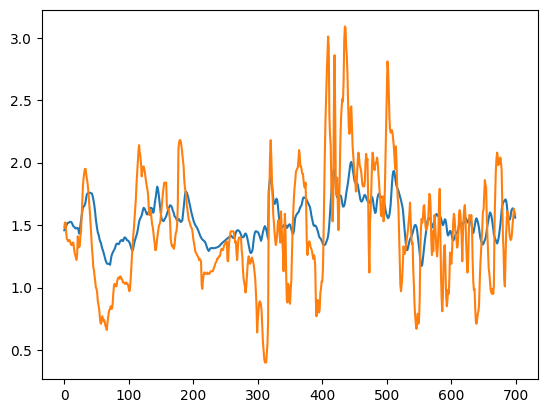

In [111]:
plt.plot(predictions[:700])
plt.plot(actuals[:700])

# Adjusted implementation

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(StackedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob).to(device)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 512).to(device)
        self.fc2 = nn.Linear(512, 128).to(device)
        self.fc3 = nn.Linear(128, output_size).to(device)
        
        # Activation functions
        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden and cell state for LSTM layers
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # LSTM layers
        out, _ = self.lstm(x, (h0, c0))
        
        # Fully connected layers
        out = out[:, -1, :]  # Get the last time step output
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

input_size = 4
hidden_size = 128
num_layers = 3  # Increased number of layers
output_size = 1
dropout_prob = 0.3  # Adjusted dropout probability

model = StackedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjusted learning rate

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.float())
            total_loss += loss.item()
        
        avg_loss = total_loss / len(val_loader)
        print(f'Test Loss: {avg_loss:.4f}')

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()

rmse = np.sqrt(np.mean((actuals - predictions) ** 2))
print(f'RMSE on validation set: {rmse}')


Epoch [1/200], Training Loss: 35203.0703
Epoch [2/200], Training Loss: 22000.3184
Epoch [3/200], Training Loss: 7961.3179
Epoch [4/200], Training Loss: 1034.5590
Epoch [5/200], Training Loss: 1048.2874
Epoch [6/200], Training Loss: 1102.4125
Epoch [7/200], Training Loss: 1028.5206
Epoch [8/200], Training Loss: 1086.0441
Epoch [9/200], Training Loss: 1013.8212
Epoch [10/200], Training Loss: 1071.3053
Epoch [11/200], Training Loss: 997.2539
Epoch [12/200], Training Loss: 1055.6143
Epoch [13/200], Training Loss: 979.7195
Epoch [14/200], Training Loss: 1038.6240
Epoch [15/200], Training Loss: 1070.9220
Epoch [16/200], Training Loss: 1017.6856
Epoch [17/200], Training Loss: 1078.3820
Epoch [18/200], Training Loss: 1002.6812
Epoch [19/200], Training Loss: 1061.5090
Epoch [20/200], Training Loss: 985.4977
Epoch [21/200], Training Loss: 1046.4794
Epoch [22/200], Training Loss: 985.1388
Epoch [23/200], Training Loss: 1045.7357
Epoch [24/200], Training Loss: 981.0363
Epoch [25/200], Training Los

# Testing

In [24]:
# Load processed data
# filename = '588_combined_segments_test.pkl'
# # Load the dictionary from the file
# with open(filename, 'rb') as f:
#     loaded_df_dict = pickle.load(f)

# # Verify the content

# print(loaded_df_dict['segment_1'])
# print(loaded_df_dict['segment_2'])
# bolus_updated_segments_test = loaded_df_dict

In [30]:
filepath_test = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/test/591-ws-testing.xml"
glucose_test = read_ohio(filepath_test, "glucose_level", True)
glucose_df_test = transfer_into_table(glucose_test)
segments_test = segement_data_as_15min(glucose_df_test) # segment

In [31]:
#Include meal:
meal_test = read_ohio(filepath_test, "meal", True)
flattened_meal_data_test = [item[0] for item in meal_test]  # Take the first (and only) item from each sublist
# Convert to DataFrame
meal_df_test = pd.DataFrame(flattened_meal_data_test)
meal_df_test['assigned'] = False
empty_d = {"ts": [], "carb_effect": []}
whole_meal_effect_df_test = pd.DataFrame(data = empty_d)
for index, meal_row in meal_df_test.iterrows():
    meal_effect_df_test = expand_meal_entry(meal_row)

    # Merge the DataFrames on the 'ts' column with an outer join
    merged_df_test = pd.merge(whole_meal_effect_df_test, meal_effect_df_test, on='ts', how='outer', suffixes=('_df1', '_df2'))

    # Fill NaN values with 0 for the carb_effect columns
    merged_df_test['carb_effect_df1'] = merged_df_test['carb_effect_df1'].fillna(0)
    merged_df_test['carb_effect_df2'] = merged_df_test['carb_effect_df2'].fillna(0)

    # Sum the carb_effect values
    merged_df_test['carb_effect'] = merged_df_test['carb_effect_df1'] + merged_df_test['carb_effect_df2']

    # Keep only the required columns
    whole_meal_effect_df_test = merged_df_test[['ts', 'carb_effect']]

whole_meal_effect_df_test['assigned'] = False
meal_updated_segments_test = update_segments_with_meals(segments_test, whole_meal_effect_df_test)

C:\Users\username\AppData\Local\Temp\ipykernel_40720\3656319066.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whole_meal_effect_df_test['assigned'] = False


In [ ]:
# Include bolus:
bolus_test = read_ohio_bolus_tempbasal(filepath_test, "bolus", True)
flattened_bolus_data_test = [item[0] for item in bolus_test]  # Take the first (and only) item from each sublist
# Convert to DataFrame
bolus_df_test = pd.DataFrame(flattened_bolus_data_test)

empty_b = {"ts": [], "bolus_effect": []}
whole_bolus_effect_df_test = pd.DataFrame(data = empty_b)

for index, bolus_row in bolus_df_test.iterrows():
    bolus_effect_df_test = expand_bolus_entry(bolus_row)

    # Merge the DataFrames on the 'ts' column with an outer join
    merged_df_test = pd.merge(whole_bolus_effect_df_test, bolus_effect_df_test, on='ts', how='outer', suffixes=('_df1', '_df2'))

    # Fill NaN values with 0 for the carb_effect columns
    merged_df_test['bolus_effect_df1'] = merged_df_test['bolus_effect_df1'].fillna(0)
    merged_df_test['bolus_effect_df2'] = merged_df_test['bolus_effect_df2'].fillna(0)
    

    # Sum the carb_effect values
    merged_df_test['bolus_effect'] = merged_df_test['bolus_effect_df1'] + merged_df_test['bolus_effect_df2']

    # Keep only the required columns
    whole_bolus_effect_df_test = merged_df_test[['ts', 'bolus_effect']]

whole_bolus_effect_df_test["assigned"] = False
bolus_updated_segments_test = update_segments_with_bolus(meal_updated_segments_test, whole_bolus_effect_df_test)

In [33]:
# Process step information
steps_test = read_ohio(filepath_test, "basis_steps", True)
flattened_steps_data_test = [item[0] for item in steps_test]  # Take the first (and only) item from each sublist
# Convert to DataFrame
step_df_test = pd.DataFrame(flattened_steps_data_test)

accumulate_step_list_test = []
# test_segment = segments["segment_1"]
for segment_name, segment_df in bolus_updated_segments_test.items():
    accumulate_step_list_test = []
    for index, cgm_row in segment_df.iterrows():
        current = cgm_row['timestamp']
        first_timestamp = current - timedelta(minutes=50)
        window_list_test= pd.date_range(start=first_timestamp, end=current, freq='5min')

        accumulated_step_test = compute_accumulated_step(window_list_test, step_df_test)
        accumulate_step_list_test.append(accumulated_step_test)
    segment_df['steps'] = accumulate_step_list_test



In [34]:
# Prepare for training
features_list_test, labels_list_test, raw_glu_list_test = prepare_dataset(bolus_updated_segments_test, 6, 6)

# Build training and validation loader
features_array_test = np.array(features_list_test)
labels_array_test = np.array(raw_glu_list_test) # Maybe need to replace this

X_test, y_test = features_array_test, labels_array_test

# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

len of features_list 2716
len of labels_list 2716


In [35]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = np.sqrt(np.mean((actuals - predictions) ** 2))
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 53.785423278808594


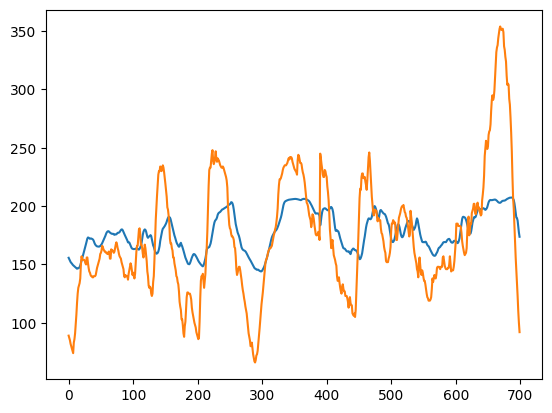

In [36]:
plt.plot(predictions[:700])
plt.plot(actuals[:700])

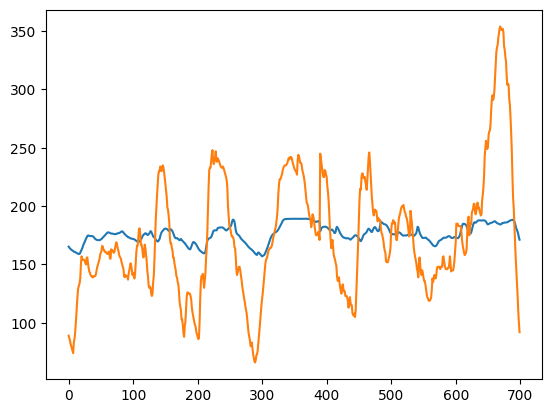

In [36]:
plt.plot(predictions[:700])
plt.plot(actuals[:700])